# Importing all necessary packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cap-4611-2021-fall-assignment-1/sample_submission.csv
/kaggle/input/cap-4611-2021-fall-assignment-1/train.csv
/kaggle/input/cap-4611-2021-fall-assignment-1/test.csv


# Reading data

In [2]:
df = pd.read_csv('/kaggle/input/cap-4611-2021-fall-assignment-1/train.csv', low_memory=False) # Training Data
test_df = pd.read_csv('/kaggle/input/cap-4611-2021-fall-assignment-1/test.csv') # Testing Data

# Viewing and cleaning imported training and testing data (EDA)

Before we begin filling null values, we should assess each column visually to determine whether or not it is significant, or duplicate information. So, we will take a closer look at the below DataFrame head.

In [3]:
df.head() # Viewing first 5 rows of training data

,id,Data As Of,Start Date,End Date,Group,Year,Month,MMWR Week,Week-Ending Date,HHS Region,Race and Hispanic Origin Group,Age Group,COVID-19 Deaths,Total Deaths,Footnote
0,0,09/22/2021,12/29/2019,2020-01-04,By Week,2019/2020,NaN,1.0,01/04/2020,United States,Hispanic,0-4 years,0.0,104.0,NaN
1,1,09/22/2021,12/29/2019,2020-01-04,By Week,2019/2020,NaN,1.0,01/04/2020,United States,Hispanic,5-17 years,0.0,41.0,NaN
2,2,09/22/2021,12/29/2019,2020-01-04,By Week,2019/2020,NaN,1.0,01/04/2020,United States,Hispanic,18-29 years,0.0,190.0,NaN
3,3,09/22/2021,12/29/2019,2020-01-04,By Week,2019/2020,NaN,1.0,01/04/2020,United States,Hispanic,30-39 years,0.0,237.0,NaN
4,4,09/22/2021,12/29/2019,2020-01-04,By Week,2019/2020,NaN,1.0,01/04/2020,United States,Hispanic,40-49 years,0.0,325.0,NaN


We will remove the following columns right off the bat as they are purely redundant:
* 'id,' 'Data As Of,' 'Group' as the row index column contains the same information
* 'End Date,' 'Year,' and 'Week-Ending Date' as is directly correlates to 'Start Date,' which doesn't give us any valuable insight
* 'HHS Region' is irrelevant as we are not concerned with regional deaths but deaths in the US as a whole
* 'Total Deaths' is also irrelevant as we are only concerned with 'COVID-19 Deaths'
* 'Footnote' is largely blank and is extraneous information

In [4]:
df = df.drop(['id', 'Data As Of', 'End Date', 'Group', 'Year', 'Week-Ending Date', 'HHS Region', 'Total Deaths', 'Footnote'], axis=1) # Dropping all unnecessary data
df.head() # Viewing first 5 rows of cleaned data

,Start Date,Month,MMWR Week,Race and Hispanic Origin Group,Age Group,COVID-19 Deaths
0,12/29/2019,NaN,1.0,Hispanic,0-4 years,0.0
1,12/29/2019,NaN,1.0,Hispanic,5-17 years,0.0
2,12/29/2019,NaN,1.0,Hispanic,18-29 years,0.0
3,12/29/2019,NaN,1.0,Hispanic,30-39 years,0.0
4,12/29/2019,NaN,1.0,Hispanic,40-49 years,0.0


# Feature Engineering (and more EDA)
We will engineer a new feature to more easily work with the date of each death--a 'month' column. 

In [5]:
df['Month'] = pd.DatetimeIndex(df['Start Date']).month # Generating new functional column to better represent 'Start Date' data
df.head() # Viewing first 5 rows of with newly engineered data

,Start Date,Month,MMWR Week,Race and Hispanic Origin Group,Age Group,COVID-19 Deaths
0,12/29/2019,12,1.0,Hispanic,0-4 years,0.0
1,12/29/2019,12,1.0,Hispanic,5-17 years,0.0
2,12/29/2019,12,1.0,Hispanic,18-29 years,0.0
3,12/29/2019,12,1.0,Hispanic,30-39 years,0.0
4,12/29/2019,12,1.0,Hispanic,40-49 years,0.0


Now that we have only the features we are interested in, we will check for missing values.

In [6]:
df.isnull().sum() # Checking which columns have null values

Start Date                            0
Month                                 0
MMWR Week                         14256
Race and Hispanic Origin Group        0
Age Group                             0
COVID-19 Deaths                   14926
dtype: int64

In order to choose a reasonable method for imputing missing values, we will count how many rows we have in our DataFrame. 

In [7]:
df.shape 

(72864, 6)

We will also observe basic statistics of our data.

In [8]:
df.describe()

,Month,MMWR Week,COVID-19 Deaths
count,72864.000000,58608.000000,57938.000000
mean,5.500000,22.459459,53.730626
std,3.468829,15.166940,682.752171
min,1.000000,1.000000,0.000000
25%,3.000000,10.000000,0.000000
50%,5.000000,19.000000,0.000000
75%,8.000000,35.000000,0.000000
max,12.000000,53.000000,94129.000000


We will also observe correlational values and plot them.

                    Month  MMWR Week  COVID-19 Deaths
Month            1.000000   0.923204        -0.011360
MMWR Week        0.923204   1.000000         0.040434
COVID-19 Deaths -0.011360   0.040434         1.000000


<AxesSubplot:>

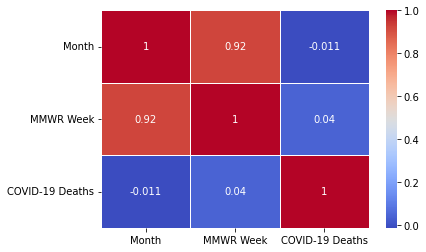

In [9]:
print(df.corr())
sns.heatmap(df.corr(), annot=True, linewidths=.7, cmap='coolwarm')

According to the above heatmap, it is apparent that there is a strong correlation between MMWR week and COVID-19 deaths. 

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72864 entries, 0 to 72863
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Start Date                      72864 non-null  object 
 1   Month                           72864 non-null  int64  
 2   MMWR Week                       58608 non-null  float64
 3   Race and Hispanic Origin Group  72864 non-null  object 
 4   Age Group                       72864 non-null  object 
 5   COVID-19 Deaths                 57938 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 3.3+ MB


As there is missing values found in only the 'MMWR Week' and 'COVID-19 Deaths' columns, we will fill each missing value with its column's respective mean value. 

In [11]:
values = {'MMWR Week': np.mean(df['MMWR Week']), 'COVID-19 Deaths': np.mean(df['COVID-19 Deaths'])}
df = df.fillna(value=values)
df.isnull().sum() # Ensuring all null values have been replaced

Start Date                        0
Month                             0
MMWR Week                         0
Race and Hispanic Origin Group    0
Age Group                         0
COVID-19 Deaths                   0
dtype: int64

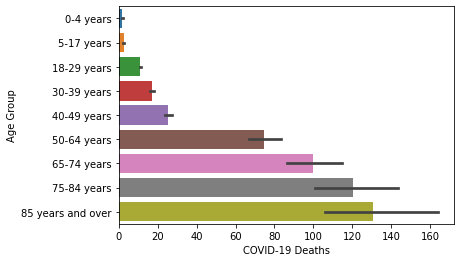

In [12]:
ax = sns.barplot(x="COVID-19 Deaths", y="Age Group", data=df)

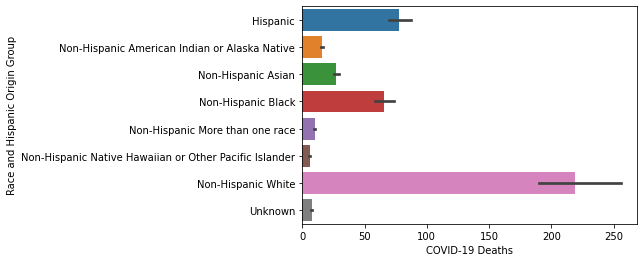

In [13]:
ax = sns.barplot(x="COVID-19 Deaths", y="Race and Hispanic Origin Group", data=df)

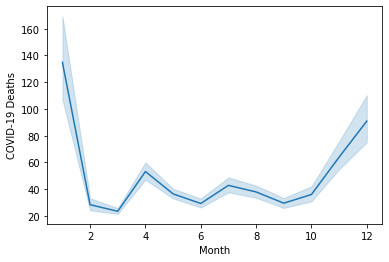

In [14]:
ax = sns.lineplot(x="Month", y="COVID-19 Deaths", data=df)

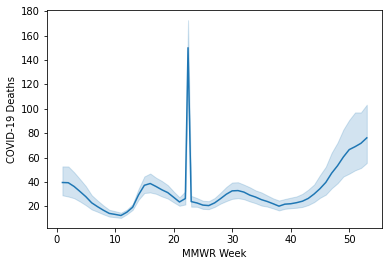

In [15]:
ax = sns.lineplot(x="MMWR Week", y="COVID-19 Deaths", data=df)

In [16]:
df_dummies = pd.get_dummies(df) # Generating dummy values for each object
print(df_dummies.head()) # Viewing first 5 rows of each dummy DataFrame
df = df.drop(['Start Date', 'Race and Hispanic Origin Group', 'Age Group'], axis=1) # Dropping object columns

   Month  MMWR Week  COVID-19 Deaths  Start Date_01/01/2020  \
0     12        1.0              0.0                      0   
1     12        1.0              0.0                      0   
2     12        1.0              0.0                      0   
3     12        1.0              0.0                      0   
4     12        1.0              0.0                      0   

   Start Date_01/01/2021  Start Date_01/03/2021  Start Date_01/05/2020  \
0                      0                      0                      0   
1                      0                      0                      0   
2                      0                      0                      0   
3                      0                      0                      0   
4                      0                      0                      0   

   Start Date_01/10/2021  Start Date_01/12/2020  Start Date_01/17/2021  ...  \
0                      0                      0                      0  ...   
1                 

# Running train_test_split to split Training Data into random train and test subsets

In [17]:
X = df.drop('COVID-19 Deaths', axis=1) # Assigning all columns except COVID-19 Deaths to 'X'
y = df['COVID-19 Deaths'].values # Assigning only COVID-19 Deaths column to 'y'
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False, random_state=1)

# Generating Models and Fitting Data to those models

Ordinary Least Squares model (Linear Regression)

In [18]:
model_lin = LinearRegression() # Creating Linear Regression model
model_lin.fit(X_train, y_train) # Fitting training data to model
predictions_lin = model_lin.predict(X_test) # Predicting test data
score_lin = r2_score(y_test, predictions_lin) # Scoring predictions against test data
print(score_lin) # Display score

-0.007407027596730842


Ridge Regression

In [19]:
model_ridge = Ridge() # Creating Ridge Regression model
model_ridge.fit(X_train, y_train) # Fitting training data to model
predictions_ridge = model_ridge.predict(X_test) # Predicting test data
score_ridge = r2_score(y_test, predictions_ridge) # Scoring predictions against test data
print(score_ridge) # Display score

-0.007407031081704041


Lasso Regression

In [20]:
model_lasso = Lasso()  # Creating Lasso Regression model
model_lasso.fit(X_train, y_train) # Fitting training data to model
predictions_lasso = model_lasso.predict(X_test) # Predicting test data
score_lasso = r2_score(y_test, predictions_lasso) # Scoring predictions against test data
print(score_lasso) # Display score

-0.007536525964022545


Elastic Net Regression

In [21]:
model_elastic = ElasticNet() # Creating Elastic Net Regression model
model_elastic.fit(X_train, y_train) # Fitting training data to model
predictions_elastic = model_elastic.predict(X_test) # Predicting test data
score_elastic = r2_score(y_test, predictions_elastic) # Scoring predictions against test data
print(score_elastic) # Display score

-0.0075376706464851395


# Evaluating Models Against Test Data

                  0
count  14573.000000
mean      30.941102
std        6.094496
min       18.919649
25%       26.039695
50%       31.379730
75%       36.719764
max       38.499776


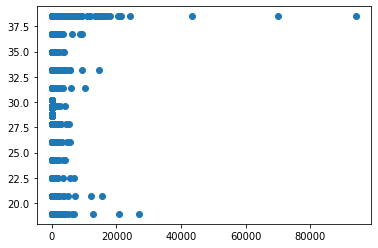

In [22]:
df_lin = pd.DataFrame(predictions_lin) # Creating DataFrame of Ordinary Least Squares (Linear) Regression predictions
print(df_lin.describe()) # Display summary statistics for this distribution
plt.scatter(y_test, predictions_lin) # Graph distribution of validation scores

                  0
count  14573.000000
mean      30.941096
std        6.094432
min       18.919769
25%       26.039740
50%       31.379719
75%       36.719698
max       38.499690


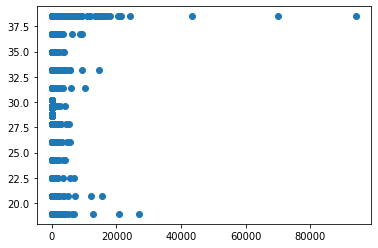

In [23]:
df_ridge = pd.DataFrame(predictions_ridge) # Creating DataFrame of Ridge Regression predictions
print(df_ridge.describe()) # Display summary statistics for this distribution
plt.scatter(y_test, predictions_ridge) # Graph distribution of validation scores

                  0
count  14573.000000
mean      30.712434
std        3.775356
min       23.285747
25%       27.690819
50%       30.994624
75%       34.298428
max       35.399696


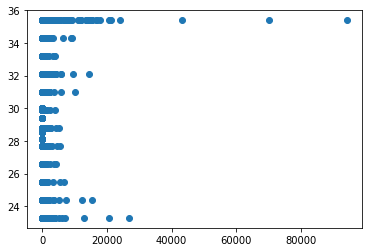

In [24]:
df_lasso = pd.DataFrame(predictions_lasso) # Creating DataFrame of Lasso Regression predictions
print(df_lasso.describe()) # Display summary statistics for this distribution
plt.scatter(y_test, predictions_lasso) # Graph distribution of validation scores

                  0
count  14573.000000
mean      30.710393
std        3.755399
min       23.323379
25%       27.705042
50%       30.991289
75%       34.277536
max       35.372952


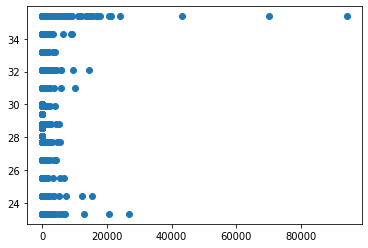

In [25]:
df_elastic = pd.DataFrame(predictions_elastic) # Creating DataFrame of Elastic Regression predictions
print(df_elastic.describe()) # Display summary statistics for this distribution
plt.scatter(y_test, predictions_elastic) # Graph distribution of validation scores

# Saving best model as 'submission.csv'

In [26]:
output = pd.DataFrame({'id': test_df['id'], 'COVID-19 Deaths': predictions_lin[:1152]}) # Creating output DataFrame
output.to_csv('submission.csv', index=False) # Saving output DataFrame as CSV
print('Your submission was successfully saved') # Asserting submission was successfully saved

Your submission was successfully saved
